##### Get a boundary of data to read from, to match OSM region data

In [1]:
import pyrosm

/mnt/c/Users/Alfred/CLionProjects/outbreak-sim/python/venv/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Get London's OpenStreetMap data
fp = pyrosm.get_data("London", update=True)
print(fp)
# Initialize the OSM object 
osm = pyrosm.OSM(fp)

Downloaded Protobuf data 'London.osm.pbf' (66.79 MB) to:
'/tmp/pyrosm/London.osm.pbf'
/tmp/pyrosm/London.osm.pbf


<AxesSubplot:>

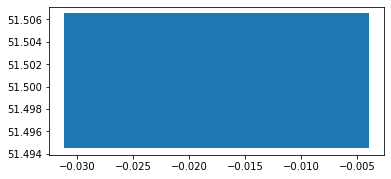

In [3]:
# # Read all boundaries using the default settings
# boundaries = osm.get_boundaries()

# # pick a small subset for testing
# boundary = osm.get_boundaries(name="London Borough of Tower Hamlets")
# boundary.plot()

import geopandas as gpd
from shapely.geometry import box

bbox = box(-0.0311018374,51.4945200196,-0.0039793398,51.5065151114)
boundary = gpd.GeoDataFrame({'geometry': bbox}, index=[0])
boundary.plot()

##### Load WorldPop Dataset and transform to match boundary

In [4]:
import geopandas as gpd
import rasterio
import rioxarray as rxr
from matplotlib import pyplot as plt

In [5]:
uk_wp = rxr.open_rasterio('../data/gbr_ppp_2020_UNadj_constrained.tif', masked=True).squeeze()
uk_wp.rio.crs  # make sure the crs is EPSG:4326 (WGS84) to match the unprojected OSM boundary

CRS.from_epsg(4326)

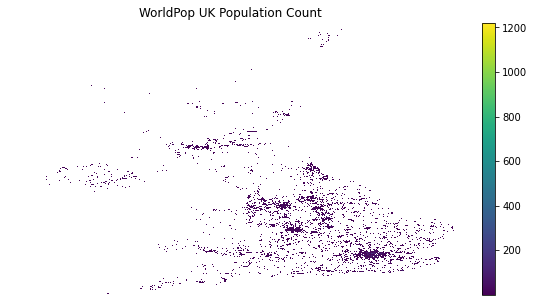

In [6]:
f, ax = plt.subplots(figsize=(10, 5))
uk_wp.plot.imshow()
ax.set(title="WorldPop UK Population Count")

ax.set_axis_off()
plt.show()

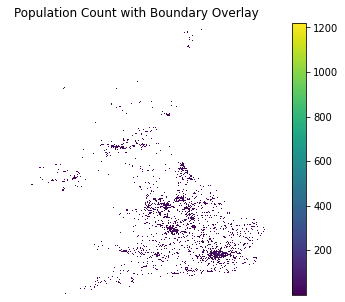

In [7]:
f, ax = plt.subplots(figsize=(10, 5))
uk_wp.plot.imshow(ax=ax)

boundary.plot(ax=ax, alpha=.8)
ax.set(title="Population Count with Boundary Overlay")

ax.set_axis_off()
plt.show()

In [83]:
from shapely.geometry import mapping
from rasterio.crs import CRS
from rasterio.enums import Resampling

wp_clipped = uk_wp.rio.clip(boundary.geometry.apply(mapping))
default = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700))
bilinear = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.bilinear)
cubic = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.cubic)
average = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.average)
cubic_spline = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.cubic_spline)
lanczos = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.lanczos)
nearest = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.nearest)
q1 = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.q1)
q3 = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700), resampling=Resampling.q3)

In [84]:
print(f"Unprojected: {float(wp_clipped.sum())}")
print(f"Default: {float(default.sum())}")
print(f"Bilinear: {float(bilinear.sum())}")
print(f"Cubic: {float(cubic.sum())}")
print(f"Average: {float(average.sum())}")
print(f"Cubic Spline: {float(cubic_spline.sum())}")
print(f"Lanczos: {float(lanczos.sum())}")
print(f"Nearest: {float(nearest.sum())}")
print(f"Q1: {float(q1.sum())}")
print(f"Q3: {float(q3.sum())}")

Unprojected: 25240.96318078041
Default: 32729.115977287292
Bilinear: 32464.85843413583
Cubic: 32550.158003036
Average: 37390.480654152234
Cubic Spline: 32464.69845433173
Lanczos: 32322.799749554575
Nearest: 32729.115977287292
Q1: 23230.44679260254
Q3: 44865.73012113571


Text(0.5, 1.0, 'Q2')

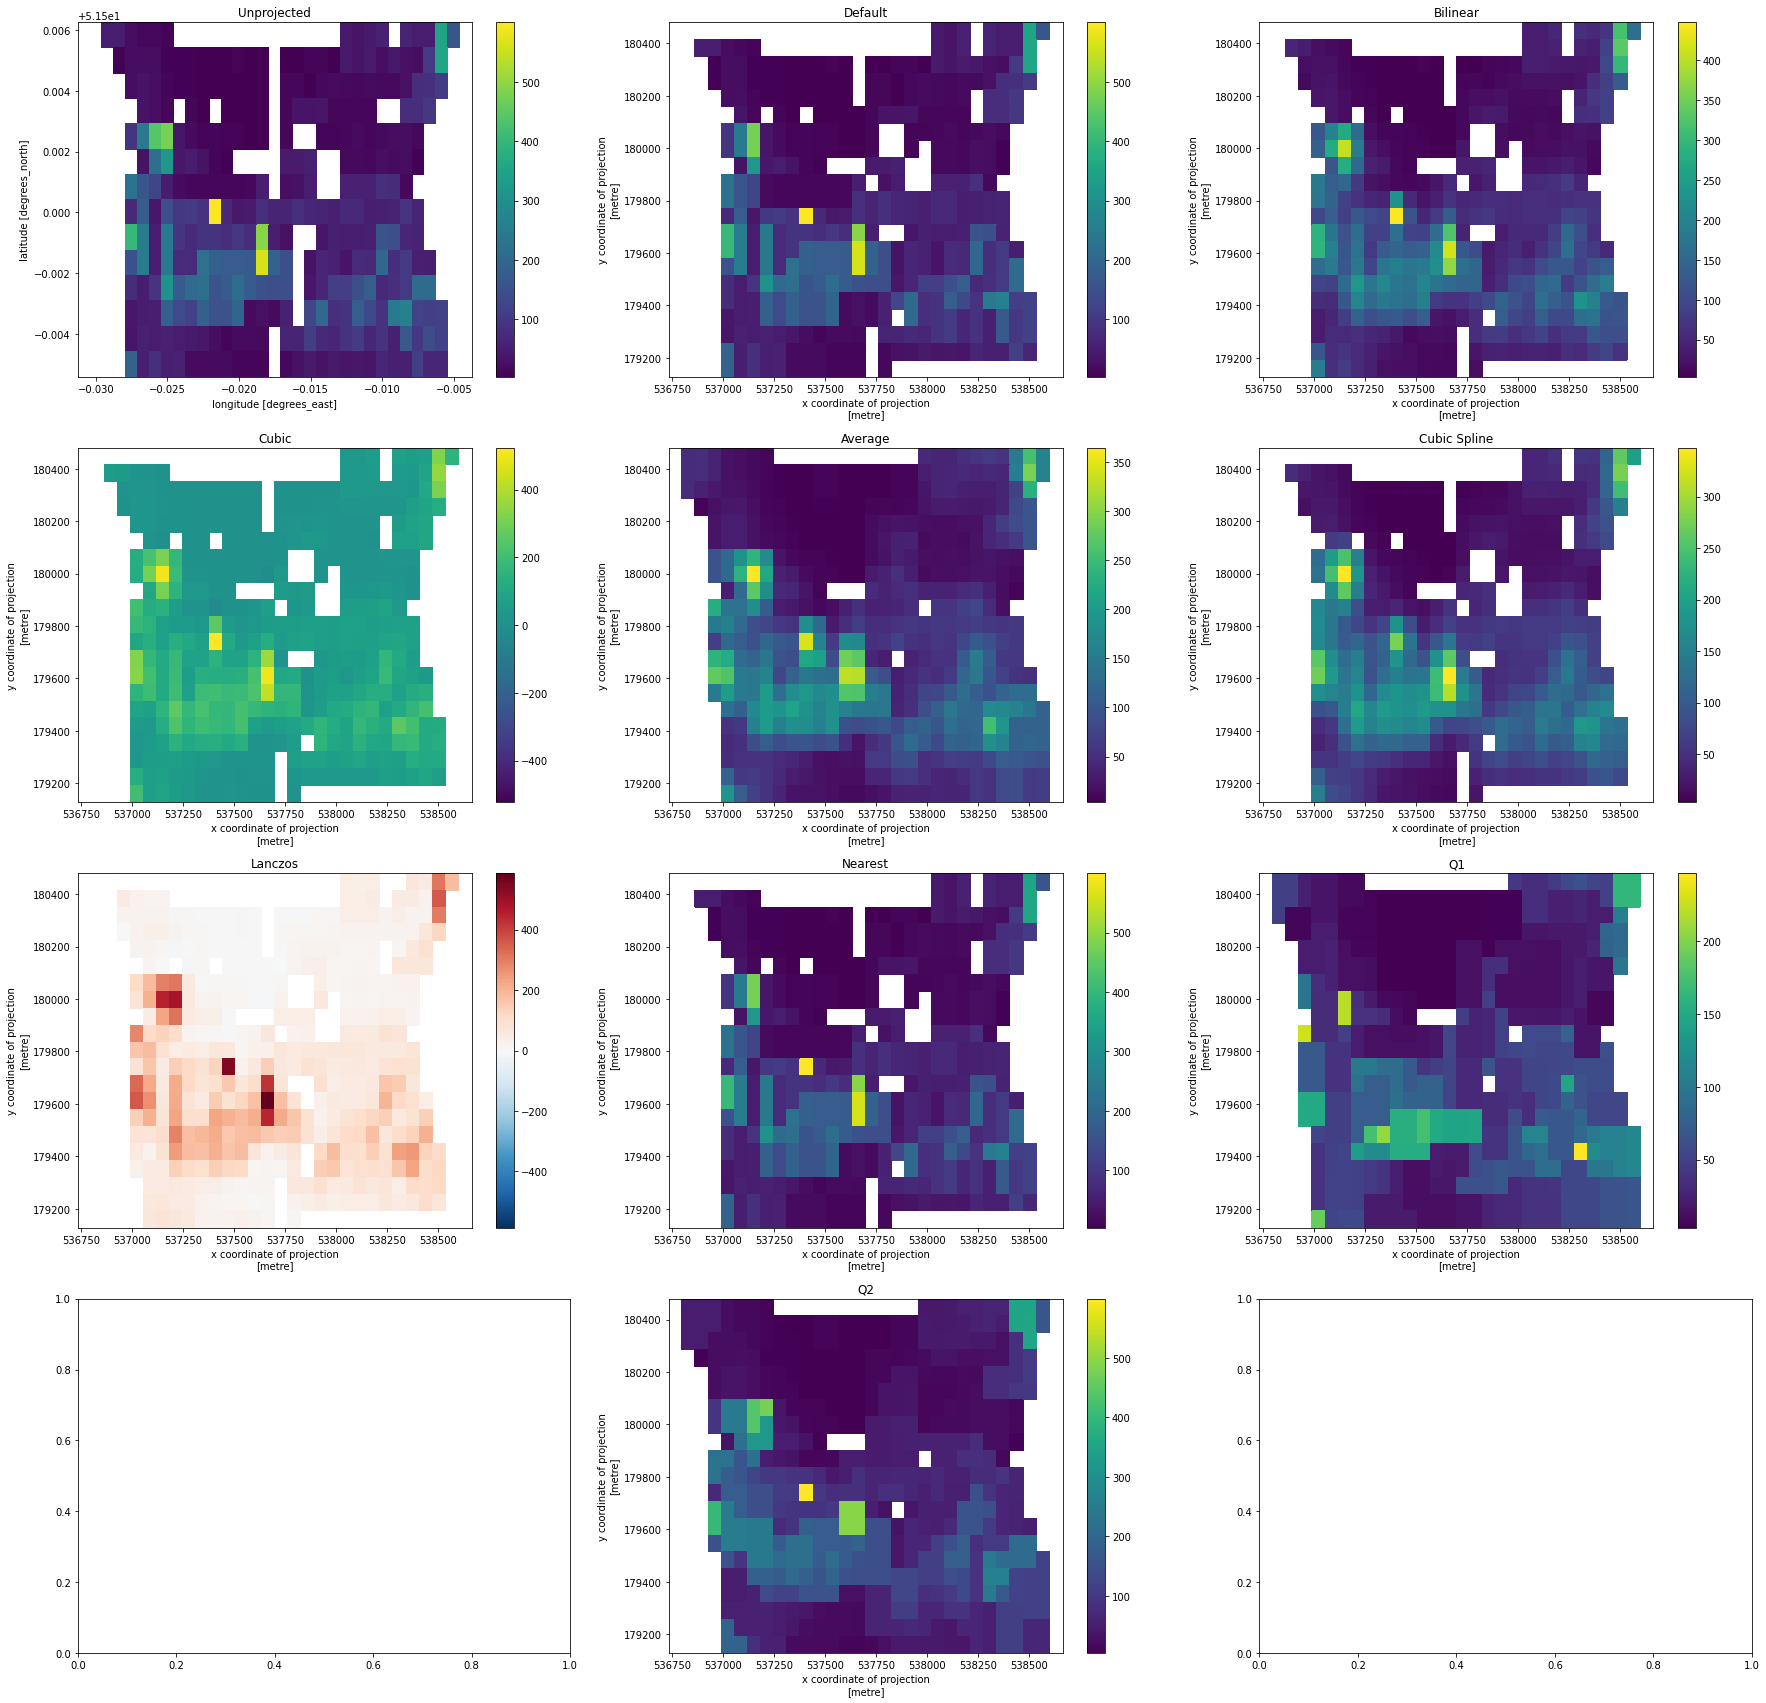

In [90]:
f, ax = plt.subplots(nrows=4, ncols=3, figsize=(30, 30))

wp_clipped.plot(ax=ax[0, 0])
ax[0, 0].set_title("Unprojected")

default.plot(ax=ax[0, 1])
ax[0, 1].set_title("Default")


bilinear.plot(ax=ax[0, 2])
ax[0, 2].set_title("Bilinear")


cubic.plot(ax=ax[1, 0], cmap='viridis')
ax[1, 0].set_title("Cubic")


average.plot(ax=ax[1, 1])
ax[1, 1].set_title("Average")


cubic_spline.plot(ax=ax[1, 2])
ax[1, 2].set_title("Cubic Spline")


lanczos.plot(ax=ax[2, 0])
ax[2, 0].set_title("Lanczos")


nearest.plot(ax=ax[2, 1])
ax[2, 1].set_title("Nearest")


q1.plot(ax=ax[2, 2])
ax[2, 2].set_title("Q1")

q3.plot(ax=ax[3, 1])
ax[3, 1].set_title("Q2")

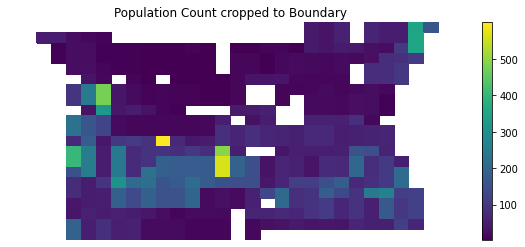

In [10]:
from shapely.geometry import mapping
from rasterio.crs import CRS

wp_clipped = uk_wp.rio.clip(boundary.geometry.apply(mapping))
wp_clipped = wp_clipped.rio.reproject(dst_crs=CRS.from_epsg(27700))

f, ax = plt.subplots(figsize=(10, 4))
wp_clipped.plot(ax=ax)
ax.set(title="Population Count cropped to Boundary")
ax.set_axis_off()
plt.show()

In [11]:
wp_clipped.sum()

<xarray.DataArray ()>
array(32729.11597729)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [12]:
# wp_clipped.rio.to_raster('./data/tower_hamlets_wp.tif')

In [14]:
import numpy as np
out_array = np.array(wp_clipped.data)

In [15]:
out_array[np.isnan(out_array)] = 0  # replace nan's with -1
out_array = out_array.astype(int)

In [16]:
np.savetxt('../data/sm_wp.txt', out_array, fmt='%d')

In [18]:
out_array.shape

(21, 30)